<a href="https://colab.research.google.com/github/rachit-shah/adbi-project/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data and Glove Model From Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import nltk
nltk.download('popular')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Model
from keras.initializers import Constant

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.layers import Embedding

import time


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [0]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 123

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)


# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


In [0]:

!cp gdrive/'My Drive'/bbc-fulltext.zip .
!cp gdrive/'My Drive'/glove.6B.zip .
!unzip bbc-fulltext.zip > out.txt
!rm bbc/README.TXT
!unzip glove.6B.zip


"\n!cp gdrive/'My Drive'/bbc-fulltext.zip .\n!cp gdrive/'My Drive'/glove.6B.zip .\n!unzip bbc-fulltext.zip > out.txt\n!rm bbc/README.TXT\n!unzip glove.6B.zip\n"

In [0]:
#Read Data
categories = ['business','entertainment','politics','sport','tech']
df = pd.DataFrame([],columns=['category','id','text'])
for cat in categories:
  for file in os.listdir("bbc/"+cat):
      if file.endswith(".txt"):
          filepath = os.path.join("bbc/"+cat, file)
          text = open(filepath,'r', errors='ignore').read()
          s = pd.Series([cat,int(filepath.split('/')[-1][:-4]),text],index=['category','id','text'])
          df = df.append(s,ignore_index=True)

df.head()

,category,id,text
0,business,128,Qantas sees profits fly to record\n\nAustralia...
1,business,139,German jobless rate at new record\n\nMore than...
2,business,389,Egypt to sell off state-owned bank\n\nThe Egyp...
3,business,479,"Ford gains from finance not cars\n\nFord, the ..."
4,business,233,Bat spit drug firm goes to market\n\nA German ...


In [0]:
'''
#WordCloud
cat = df['category'].unique()

for i in range(0,len(cat)):
    words = ' '.join(df.loc[df['category']==cat[i], 'text'])

    wordcloud = WordCloud( 
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=800,
                          height=400
                ).generate(words)
    print(cat[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

words = ' '.join(df.loc[:, 'text'])

wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(words)
print("ALL Categories:")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
'''

'\n#WordCloud\ncat = df[\'category\'].unique()\n\nfor i in range(0,len(cat)):\n    words = \' \'.join(df.loc[df[\'category\']==cat[i], \'text\'])\n\n    wordcloud = WordCloud( \n                          stopwords=STOPWORDS,\n                          background_color=\'white\',\n                          width=800,\n                          height=400\n                ).generate(words)\n    print(cat[i])\n    plt.figure(figsize=(10, 5))\n    plt.imshow(wordcloud)\n    plt.axis(\'off\')\n    plt.show()\n\nwords = \' \'.join(df.loc[:, \'text\'])\n\nwordcloud = WordCloud( \n                      stopwords=STOPWORDS,\n                      background_color=\'white\',\n                      width=800,\n                      height=400\n            ).generate(words)\nprint("ALL Categories:")\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud)\nplt.axis(\'off\')\nplt.show()\n'

## Label Encoder
#### Use inverse_transform at the end after predicting

In [0]:
y = df['category']
X = df.drop(['category','id'],axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X,y,stratify=y, test_size=0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 1508       sport
1908        tech
2104        tech
2019        tech
1245    politics
Name: category, dtype: object ...
after: [3 4 4 ... 1 0 2] ...


In [0]:
print(np.bincount(y_train))
print(y.value_counts())
print(le.inverse_transform([i for i in range(5)]))

[408 309 333 409 321]
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
['business' 'entertainment' 'politics' 'sport' 'tech']


## Preprocess Data - (split by \n, remove periods, remove slashes)

In [0]:
#Parameters for hyperparameter  tuning
dropout = 0.4
EMBEDDING_DIM = 100
traina = True #embeedding layer trainable

In [0]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [0]:
#Preprocess both train and test separately
X_train['text'] = preprocess(X_train['text'])
X_test['text'] = preprocess(X_test['text'])

In [0]:
#Stop Words and Lemmatization   
lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['.','``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])

In [0]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('glove.6B.'+str(EMBEDDING_DIM)+'d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 28515 unique tokens.
Shape of data tensor: (1780, 1000)
Shape of label tensor: (1780, 5)


In [0]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
traina = True
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=traina)

In [0]:
#Map label name to its index
labels_index = {}
for i in range(5):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

## Train Model

In [0]:
model_name = "CNN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+traina
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_cnn = TensorBoard(log_dir='/Graph_CNN', histogram_freq=0,write_graph=True, write_images=True)

In [0]:
np.random.seed(123)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(dropout,seed=123)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(dropout,seed=123)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(dropout,seed=123)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [0]:
np.random.seed(123)
stmillis = int(round(time.time() * 1000))
history = model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping],shuffle=False)
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Train on 1424 samples, validate on 356 samples
Epoch 1/50
1424/1424 [==============================] - 1s 713us/step - loss: 1.5490 - acc: 0.3904 - val_loss: 0.9238 - val_acc: 0.7528

Epoch 00001: val_loss improved from inf to 0.92377, saving model to CNN_weights.01-0.92.hdf5
Epoch 2/50
1424/1424 [==============================] - 1s 362us/step - loss: 0.5359 - acc: 0.8223 - val_loss: 0.2840 - val_acc: 0.8989

Epoch 00002: val_loss improved from 0.92377 to 0.28404, saving model to CNN_weights.02-0.28.hdf5
Epoch 3/50
1424/1424 [==============================] - 1s 374us/step - loss: 0.2119 - acc: 0.9235 - val_loss: 0.2478 - val_acc: 0.9157

Epoch 00003: val_loss improved from 0.28404 to 0.24779, saving model to CNN_weights.03-0.25.hdf5
Epoch 4/50
1424/1424 [==============================] - 1s 373us/step - loss: 0.1334 - acc: 0.9586 - val_loss: 0.1517 - val_acc: 0.9494

Epoch 00004: val_loss improved from 0.24779 to 0.15168, saving model to CNN_weights.04-0.15.hdf5
Epoch 5/50
1424/1424 

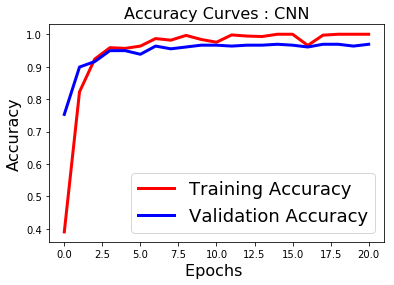

In [0]:
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig.savefig('accuracy_cnn.png')
plt.show()

In [0]:
# Save the trained weights
model.save(model_name + ".h5")

# Save model config as json
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp CNN.* gdrive/My\ Drive/

## Predict on Test Data

In [0]:
def find_test_acc(prediction):
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")

In [0]:
def predict_test(model):
  #Tokenize test data and apply model prediction
  sequences = tokenizer.texts_to_sequences(test_text)
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)
  prediction = model.predict(data)
  find_test_acc(prediction)

In [0]:
predict_test(model)

Shape of data tensor: (445, 1000)
Shape of label tensor: (1780, 5)
Test Accuracy: 97.52808988764045 %


# RNN

In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(100,dropout=0.4))(embedded_sequences)
preds = Dense(len(labels_index), activation='softmax')(x)
lstm_model = Model(sequence_input, preds)
lstm_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [0]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 100)         2851600   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 1005      
Total params: 3,013,405
Trainable params: 3,013,405
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_name = "RNN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+traina
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_rnn = TensorBoard(log_dir='./Graph_RNN', histogram_freq=0,write_graph=True, write_images=True)

In [0]:
stmillis = int(round(time.time() * 1000))
history = lstm_model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping,tensorboard_rnn])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Train on 1424 samples, validate on 356 samples
Epoch 1/50
1424/1424 [==============================] - 48s 34ms/step - loss: 1.3773 - acc: 0.4782 - val_loss: 0.9259 - val_acc: 0.6433

Epoch 00001: val_loss improved from inf to 0.92591, saving model to RNN_weights.01-0.93.hdf5
Epoch 2/50
1424/1424 [==============================] - 46s 32ms/step - loss: 0.7603 - acc: 0.7647 - val_loss: 0.7437 - val_acc: 0.7528

Epoch 00002: val_loss improved from 0.92591 to 0.74369, saving model to RNN_weights.02-0.74.hdf5
Epoch 3/50
1424/1424 [==============================] - 49s 34ms/step - loss: 0.5806 - acc: 0.8188 - val_loss: 0.3510 - val_acc: 0.9101

Epoch 00003: val_loss improved from 0.74369 to 0.35098, saving model to RNN_weights.03-0.35.hdf5
Epoch 4/50
1424/1424 [==============================] - 46s 32ms/step - loss: 0.5584 - acc: 0.8251 - val_loss: 0.6116 - val_acc: 0.7753

Epoch 00004: val_loss did not improve from 0.35098
Epoch 5/50
1424/1424 [==============================] - 46s 33ms/st

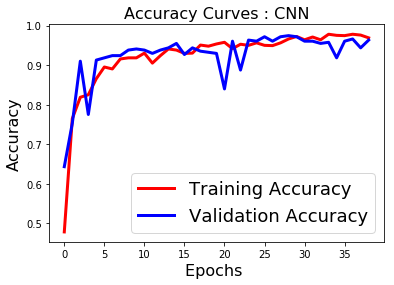

In [0]:
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig.savefig('accuracy_cnn.png')
plt.show()

In [0]:
# Save the trained weights
lstm_model.save(model_name + ".h5")

# Save model config as json
model_json = lstm_model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp RNN.* gdrive/My\ Drive/

In [0]:
predict_test(lstm_model)

Shape of data tensor: (445, 1000)
Shape of label tensor: (1780, 5)
Test Accuracy: 96.85393258426967 %


## Tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-02 00:05:03--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.245.79, 3.92.108.98, 52.55.191.55, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.245.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.30M  60.7MB/s    in 0.2s    

2019-05-02 00:05:03 (60.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './Graph_RNN'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://ad564189.ngrok.io


In [0]:
!ls

accuracy_cnn.png	  gdrive
bbc			  glove.6B.100d.txt
bbc-fulltext.zip	  glove.6B.200d.txt
CNN.h5			  glove.6B.300d.txt
CNN.json		  glove.6B.50d.txt
CNN_weights.01-0.96.hdf5  glove.6B.zip
CNN_weights.01-1.18.hdf5  ngrok
CNN_weights.01-1.38.hdf5  ngrok-stable-linux-amd64.zip
CNN_weights.02-0.42.hdf5  out.txt
CNN_weights.02-0.48.hdf5  RNN.h5
CNN_weights.02-0.62.hdf5  RNN.json
CNN_weights.03-0.29.hdf5  RNN_weights.01-0.81.hdf5
CNN_weights.03-0.34.hdf5  RNN_weights.02-0.47.hdf5
CNN_weights.03-0.41.hdf5  RNN_weights.03-0.32.hdf5
CNN_weights.04-0.17.hdf5  RNN_weights.06-0.31.hdf5
CNN_weights.04-0.19.hdf5  RNN_weights.07-0.28.hdf5
CNN_weights.04-0.24.hdf5  RNN_weights.09-0.28.hdf5
CNN_weights.05-0.16.hdf5  RNN_weights.10-0.25.hdf5
CNN_weights.05-0.18.hdf5  RNN_weights.13-0.21.hdf5
CNN_weights.06-0.15.hdf5  RNN_weights.19-0.19.hdf5
CNN_weights.09-0.14.hdf5  RNN_weights.20-0.19.hdf5
CNN_weights.09-0.15.hdf5  RNN_weights.23-0.16.hdf5
CNN_weights.09-0.17.hdf5  RNN_weights.26-0.14.hdf5
CNN_weights.1